In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BertModel, BertConfig
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/mtsamples.csv'

Mounted at /content/drive


In [27]:
csv_file_path = path
df = pd.read_csv(csv_file_path)

In [28]:

df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [29]:
len(df)

4999

In [30]:
# df = df.dropna(subset=['transcription', 'keywords'])
df = df.dropna(subset=['transcription', 'keywords'], how='any')

len(df)


3898

In [31]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [32]:
import string,time
string.punctuation

punctuations = string.punctuation
punctuations += "“”•™-_0123456789—*"
# {'ê', '2', '9', '8', 'ï', 'è', 'τ', '7', '•', 'â', 'α', '™', 'ε', '’', 'î', '3', 'ô', '0', '6', '4', '—', 'ὲ', 'μ', 'ὸ', 'ç', '1', 'æ', 'π', '‘', 'à', '5', 'é', '†', 'œ', 'ρ', 'δ', '–'}
# print(punctuations)
# def remove_punctuation(text):
#     for char in punctuations:
#         text = text.replace(char,'')
#     return text

# def replace_values(text):
#     text = text.replace('.,', ' ')
#     punctuation_to_replace = '-'
#     for char in punctuation_to_replace:
#         text = text.replace(char, ' ')
#     return text

def remove_punctuation(text):
    punctuations = string.punctuation
    # punctuations = punctuations.replace('.', '')
    # punctuations = punctuations.replace(',', '')
    for char in punctuations:
        text = text.replace(char, '')
    return text


def remove_tags(text):
    # if pd.isnull(text):
    #     return text
    # else:
    #     return text.strip().split('\n')
    return text.strip().split('\n')


In [33]:
# df['transcription'] = df['transcription'].apply(replace_values)
# df['keywords'] = df['keywords'].apply(replace_values)
# print(df['transcription'].iloc[0])

df['transcription'] = df['transcription'].apply(remove_punctuation)
df['keywords'] = df['keywords'].apply(remove_punctuation)
print(df['transcription'].iloc[0])

df['transcription'] = df['transcription'].apply(remove_tags)
df['keywords'] = df['keywords'].apply(remove_tags)
print(df['transcription'].iloc[0])

df['transcription'] = df['transcription'].apply(lambda x: x[0].lower())
df['keywords'] = df['keywords'].apply(lambda x: x[0].lower())
print(df['transcription'].iloc[0])

SUBJECTIVE  This 23yearold white female presents with complaint of allergies  She used to have allergies when she lived in Seattle but she thinks they are worse here  In the past she has tried Claritin and Zyrtec  Both worked for short time but then seemed to lose effectiveness  She has used Allegra also  She used that last summer and she began using it again two weeks ago  It does not appear to be working very well  She has used overthecounter sprays but no prescription nasal sprays  She does have asthma but doest not require daily medication for this and does not think it is flaring upMEDICATIONS  Her only medication currently is Ortho TriCyclen and the AllegraALLERGIES  She has no known medicine allergiesOBJECTIVEVitals  Weight was 130 pounds and blood pressure 12478HEENT  Her throat was mildly erythematous without exudate  Nasal mucosa was erythematous and swollen  Only clear drainage was seen  TMs were clearNeck  Supple without adenopathyLungs  ClearASSESSMENT  Allergic rhinitisPL

In [10]:
df['transcription'].iloc[0]

['s']

In [11]:
len(df)

3898

Max Length :  2003
Min Length :  1


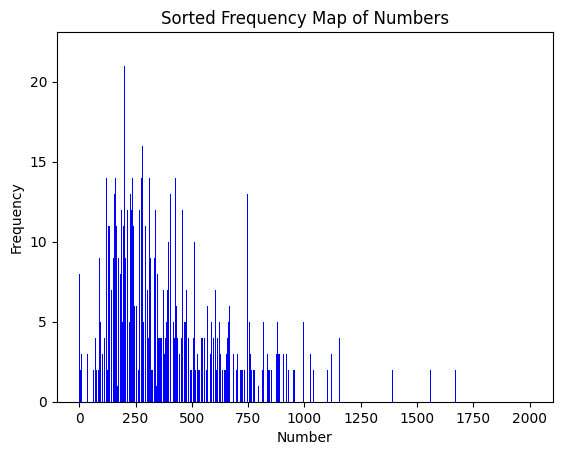

In [34]:
word_lengths = []

for sent in df['transcription']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

Max Length :  118
Min Length :  0


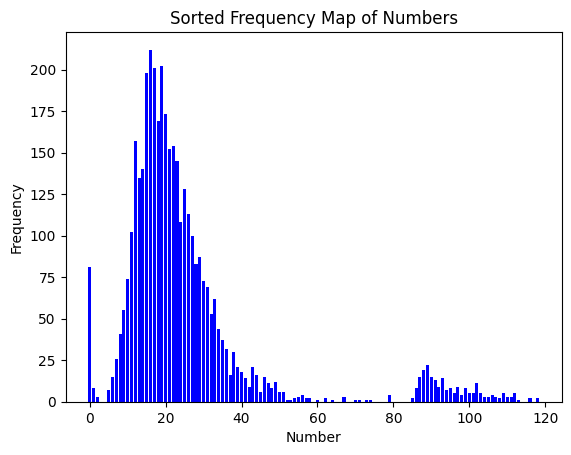

In [35]:
word_lengths = []

for sent in df['keywords']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

In [37]:
!pip install sentence_transformers -q

  Preparing metadata (setup.py) ... done


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


n_gram_range = (1, 1)
stop_words = "english"
model = SentenceTransformer('distilbert-base-nli-mean-tokens')



In [43]:
def generate_keywords(input, top_n = 20):
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([input])
    candidates = count.get_feature_names_out()
    doc_embedding = model.encode([input])
    candidate_embeddings = model.encode(candidates)
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    return keywords

In [44]:
for i in range(4):
    print("Transcription :", df['transcription'].iloc[i])
    print("Keywords :", df['keywords'].iloc[i])
    print("Result :", generate_keywords(df['transcription'].iloc[i]))
    print("="*80)

Transcription : subjective  this 23yearold white female presents with complaint of allergies  she used to have allergies when she lived in seattle but she thinks they are worse here  in the past she has tried claritin and zyrtec  both worked for short time but then seemed to lose effectiveness  she has used allegra also  she used that last summer and she began using it again two weeks ago  it does not appear to be working very well  she has used overthecounter sprays but no prescription nasal sprays  she does have asthma but doest not require daily medication for this and does not think it is flaring upmedications  her only medication currently is ortho tricyclen and the allegraallergies  she has no known medicine allergiesobjectivevitals  weight was 130 pounds and blood pressure 12478heent  her throat was mildly erythematous without exudate  nasal mucosa was erythematous and swollen  only clear drainage was seen  tms were clearneck  supple without adenopathylungs  clearassessment  all

In [49]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk

# Download NLTK data
nltk.download("punkt")

def calculate_rouge(reference, candidate):
    # Tokenize the sentences
    reference = nltk.word_tokenize(reference.lower())
    candidate = nltk.word_tokenize(candidate.lower())

    # Calculate ROUGE scores
    smoothing_function = SmoothingFunction().method1
    rouge_scores = corpus_bleu([reference], [candidate], smoothing_function=smoothing_function)

    return rouge_scores

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
i = 11
print(df['keywords'].iloc[i])
print(" ".join(generate_keywords(df['transcription'].iloc[i])))
rouge_scores = calculate_rouge(df['keywords'].iloc[i], " ".join(generate_keywords(df['transcription'].iloc[i])))
print("ROUGE Scores:", rouge_scores)

0.11334534565
